In [1]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import os
import sys
import warnings

In [2]:
articles = pd.read_csv(
    "../input/h-and-m-personalized-fashion-recommendations/articles.csv"
)
customers = pd.read_csv(
    "../input/h-and-m-personalized-fashion-recommendations/customers.csv"
)
sample_submission = pd.read_csv(
    "../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv"
)
train = pd.read_csv(
    "../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv",
    parse_dates=["t_dat"],
)

In [3]:
train.memory_usage(deep=True)

Index                      128
t_dat                254306592
customer_id         3846387204
article_id           254306592
price                254306592
sales_channel_id     254306592
dtype: int64

In [4]:
train["customer_id"] = (
    train["customer_id"].apply(lambda x: int(x[-16:], 16)).astype("int64")
)
train["article_id"] = train["article_id"].astype("int32")
train["article_id"] = "0" + train.article_id.astype("str")

In [5]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


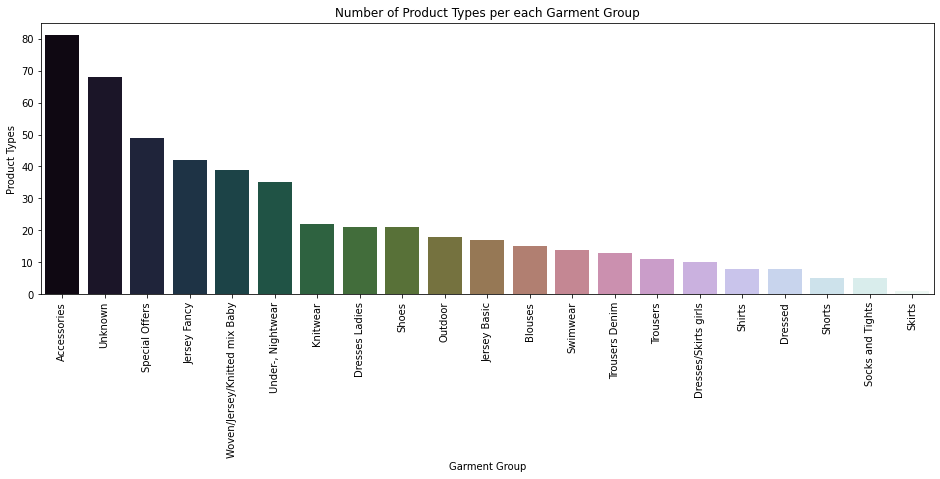

In [6]:
temp = articles.groupby(["garment_group_name"])["product_type_name"].nunique()
df = pd.DataFrame({"Garment Group": temp.index, "Product Types": temp.values})
df = df.sort_values(["Product Types"], ascending=False)
plt.figure(figsize=(16, 5))
plt.title("Number of Product Types per each Garment Group")
s = sns.barplot(x="Garment Group", y="Product Types", data=df, palette="cubehelix")
s.set_xticklabels(s.get_xticklabels(), rotation=90)
locs, labels = plt.xticks()
plt.show()

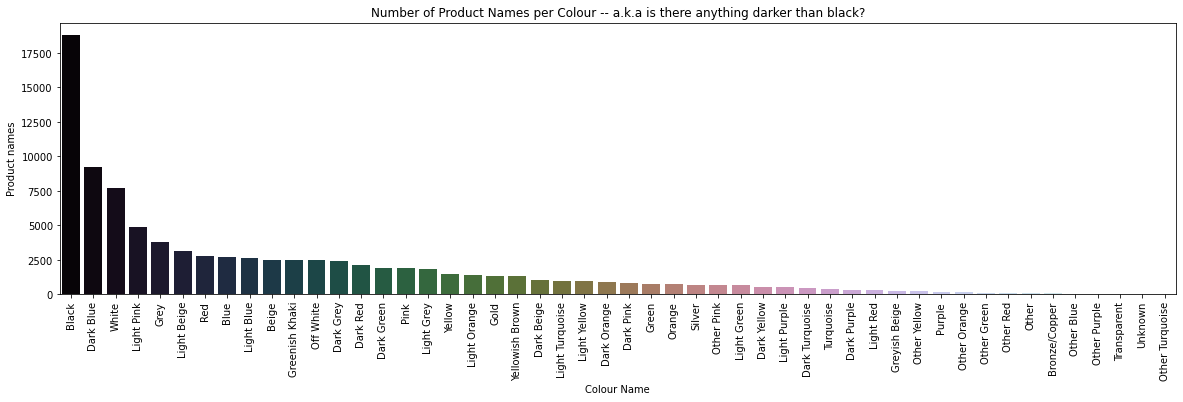

In [7]:
temp = articles.groupby(["colour_group_name"])["prod_name"].nunique()
df = pd.DataFrame({"Colour Name": temp.index, "Product names": temp.values})
df = df.sort_values(["Product names"], ascending=False)
plt.figure(figsize=(20, 5))
plt.title(
    "Number of Product Names per Colour -- a.k.a is there anything darker than black?"
)
s = sns.barplot(x="Colour Name", y="Product names", data=df, palette="cubehelix")
s.set_xticklabels(s.get_xticklabels(), rotation=90)
locs, labels = plt.xticks()
plt.show()

In [8]:
articles.groupby(["index_group_name", "index_group_no", "index_name", "index_code"])[
    "article_id"
].count()

index_group_name  index_group_no  index_name                      index_code
Baby/Children     4               Baby Sizes 50-98                G              8875
                                  Children Accessories, Swimwear  J              4615
                                  Children Sizes 134-170          I              9214
                                  Children Sizes 92-140           H             12007
Divided           2               Divided                         D             15149
Ladieswear        1               Ladies Accessories              C              6961
                                  Ladieswear                      A             26001
                                  Lingeries/Tights                B              6775
Menswear          3               Menswear                        F             12553
Sport             26              Sport                           S              3392
Name: article_id, dtype: int64

In [9]:
df_a = sqldf(
    """SELECT article_id, prod_name, product_type_name, product_group_name, colour_group_name, index_name
            FROM articles
            """
)
df_sold_qty = train["article_id"].value_counts()


df_sold_qty = df_sold_qty.reset_index()
df_sold_qty.rename(
    columns={"article_id": "sold_qty", "index": "article_id"}, inplace=True
)
top_100_sold = df_sold_qty.iloc[:100]

top_100_details = sqldf(
    """SELECT *
        FROM top_100_sold AS t
        INNER JOIN df_a AS a
        on t.article_id = a.article_id
    """
)

In [10]:
top_100_details.head()

,article_id,sold_qty,article_id,prod_name,product_type_name,product_group_name,colour_group_name,index_name
0,0706016001,50287,706016001,Jade HW Skinny Denim TRS,Trousers,Garment Lower body,Black,Divided
1,0706016002,35043,706016002,Jade HW Skinny Denim TRS,Trousers,Garment Lower body,Light Blue,Divided
2,0372860001,31718,372860001,7p Basic Shaftless,Socks,Socks & Tights,Black,Lingeries/Tights
3,0610776002,30199,610776002,Tilly (1),T-shirt,Garment Upper body,Black,Ladieswear
4,0759871002,26329,759871002,Tilda tank,Vest top,Garment Upper body,Black,Divided


In [11]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


<AxesSubplot:>

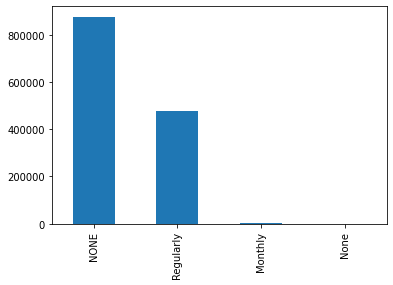

In [12]:
customers.fashion_news_frequency.value_counts().plot(kind="bar")

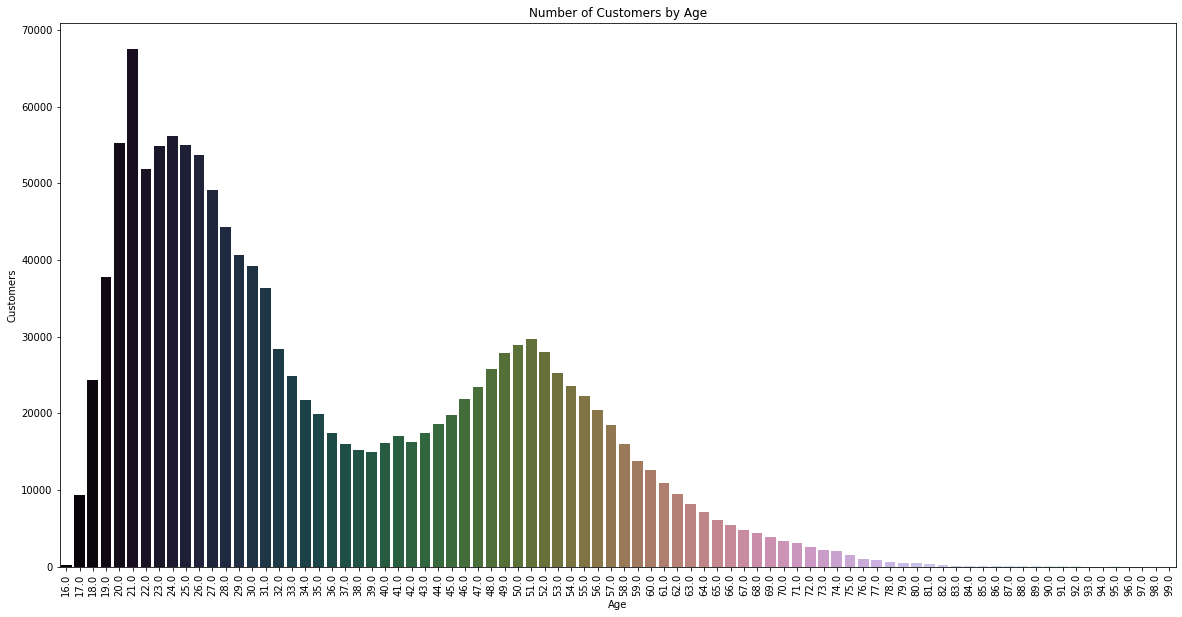

In [13]:
temp = customers.groupby(["age"])["customer_id"].count()
df = pd.DataFrame({"Age": temp.index, "Customers": temp.values})
df = df.sort_values(["Age"], ascending=False)
plt.figure(figsize=(20, 10))
plt.title(f"Number of Customers by Age")
s = sns.barplot(x="Age", y="Customers", data=df, palette="cubehelix")
s.set_xticklabels(s.get_xticklabels(), rotation=90)
locs, labels = plt.xticks()
plt.show()

In [14]:
train.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,0663713001,0.050831,2
1,2018-09-20,-6846340800584936,0541518023,0.030492,2
2,2018-09-20,-8334631767138808638,0505221004,0.015237,2
3,2018-09-20,-8334631767138808638,0685687003,0.016932,2
4,2018-09-20,-8334631767138808638,0685687004,0.016932,2


<AxesSubplot:xlabel='t_dat'>

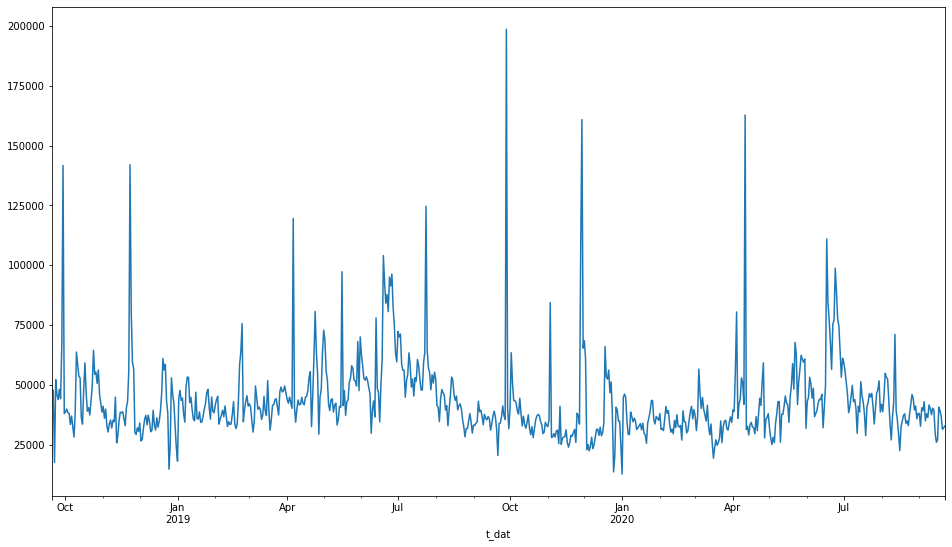

In [15]:
plt.figure(figsize=(16, 9))
train.groupby(["t_dat"])["article_id"].count().plot()

In [16]:
temp1 = train.query("article_id == '0706016001'")[["t_dat", "price"]]
temp2 = train.query("article_id == '0706016002'")[["t_dat", "price"]]
temp3 = train.query("article_id == '0372860001'")[["t_dat", "price"]]
temp4 = train.query("article_id == '0610776002'")[["t_dat", "price"]]

In [17]:
temp1["price"] = temp1["price"] * 590

In [18]:
temp1["price"].value_counts()

19.99    34760
15.99     3510
17.99     3136
16.99      928
14.39      500
         ...  
16.56        1
13.79        1
16.75        1
16.59        1
14.23        1
Name: price, Length: 563, dtype: int64

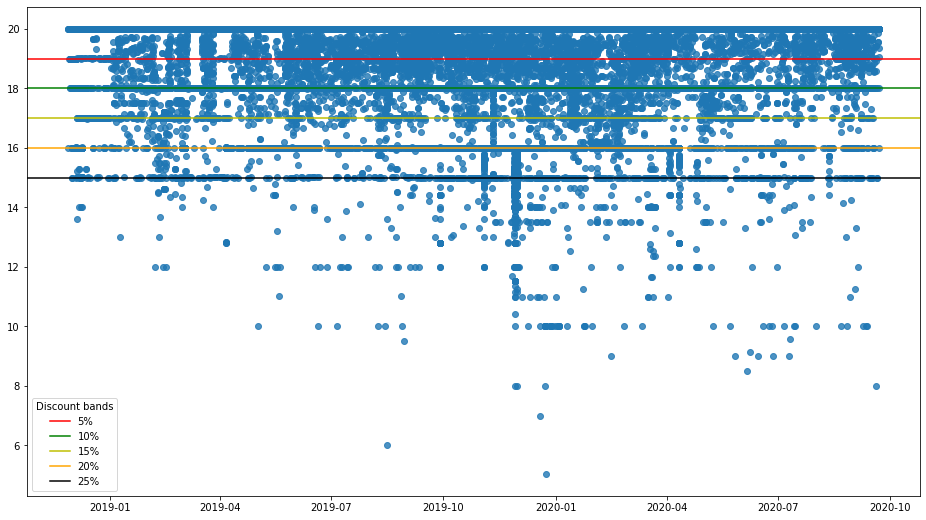

In [19]:
fig, ax = plt.subplots(figsize=(16, 9))
try:
    sns.regplot(x="t_dat", y="price", data=temp1, ax=ax)
except TypeError:
    pass
plt.axhline(y=18.99, color="r", linestyle="-", label="5%")
plt.axhline(y=17.99, color="g", linestyle="-", label="10%")
plt.axhline(y=16.99, color="y", linestyle="-", label="15%")
plt.axhline(y=15.99, color="orange", linestyle="-", label="20%")
plt.axhline(y=14.99, color="black", linestyle="-", label="25%")
plt.legend(title="Discount bands")

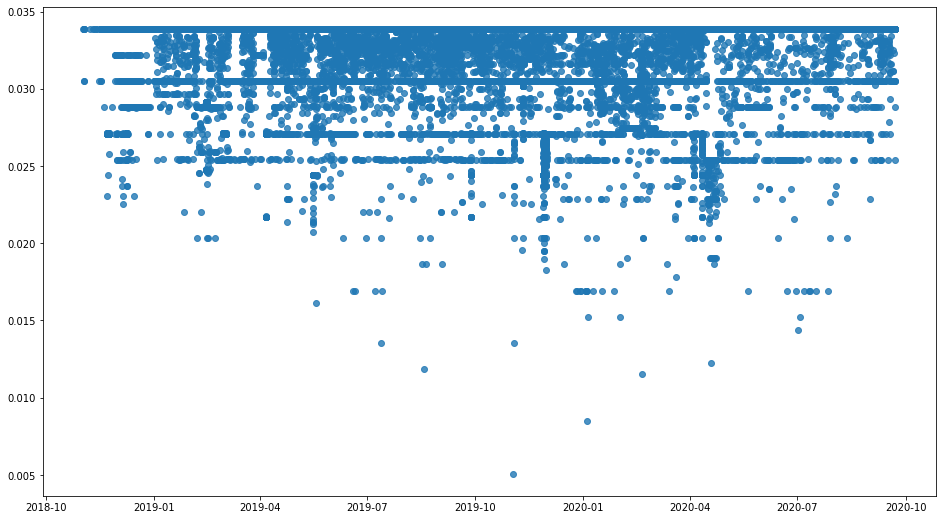

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))
try:
    sns.regplot(x="t_dat", y="price", data=temp2, ax=ax)
except TypeError:
    pass

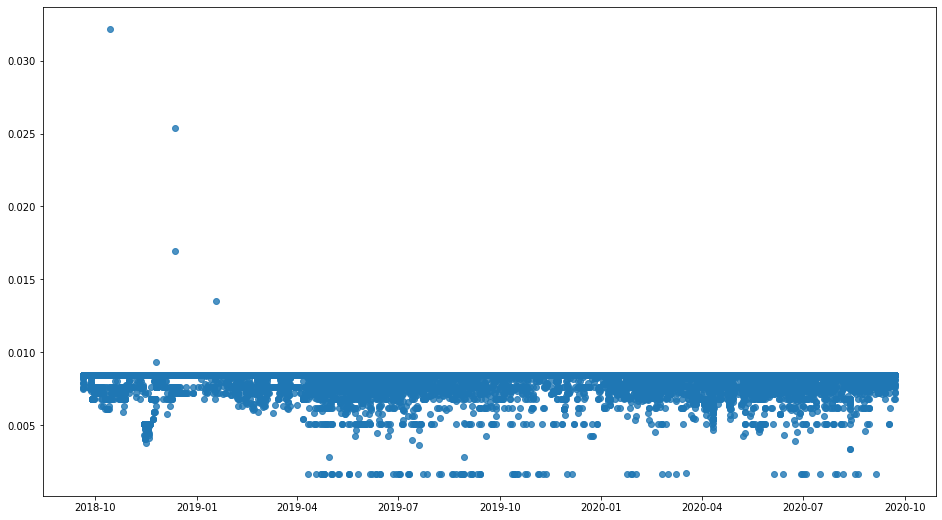

In [21]:
fig, ax = plt.subplots(figsize=(16, 9))
try:
    sns.regplot(x="t_dat", y="price", data=temp4, ax=ax)
except TypeError:
    pass

<AxesSubplot:xlabel='price', ylabel='Density'>

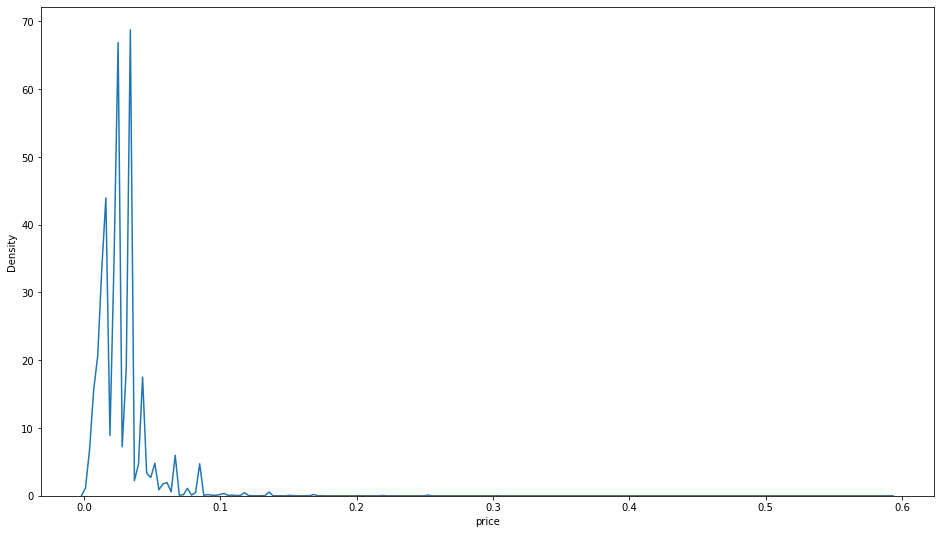

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.kdeplot(train.price, ax=ax)

In [23]:
transactions_byid = train.groupby("customer_id").count()
customer_purchases = transactions_byid.sort_values(by="price", ascending=False)["price"]

Text(0.5, 1.0, 'Purchases per customer')

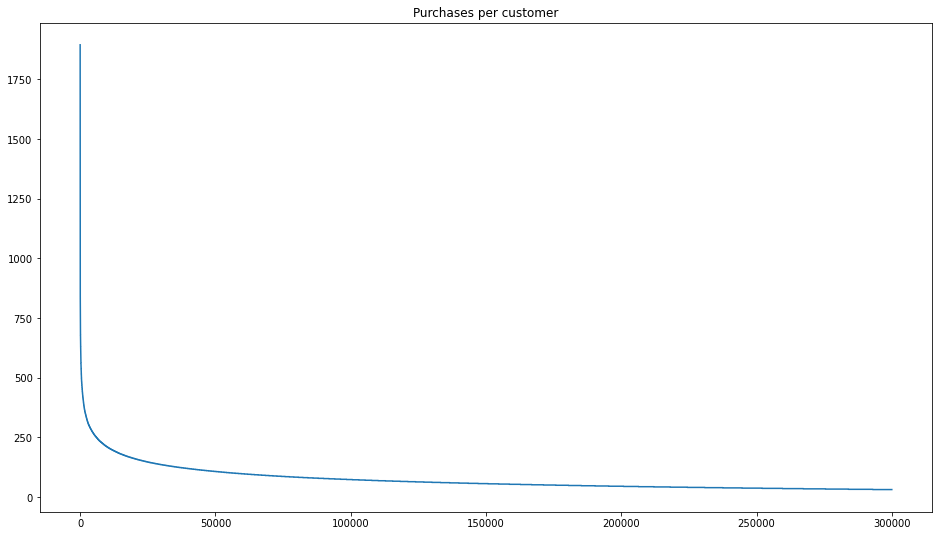

In [24]:
plt.figure(figsize=(16, 9))
plt.plot(list(range(300_000)), customer_purchases[:300_000])
plt.title("Purchases per customer")

In [25]:
spring_UK_19 = pd.date_range("2019-03-01", "2019-06-21", freq="d")
summer_UK_19 = pd.date_range("2019-06-22", "2019-09-22", freq="d")
autumn_UK_19 = pd.date_range("2019-09-23", "2019-12-21", freq="d")
winter_UK_19_20 = pd.date_range("2019-12-21", "2020-2-28", freq="d")

In [26]:
spring_UK_19_top = (
    train[train["t_dat"].isin(spring_UK_19)]["article_id"].value_counts()[0:12].index
)
summer_UK_19_top = (
    train[train["t_dat"].isin(summer_UK_19)]["article_id"].value_counts()[0:12].index
)
autumn_UK_19_top = (
    train[train["t_dat"].isin(autumn_UK_19)]["article_id"].value_counts()[0:12].index
)
winter_UK_19_20_top = (
    train[train["t_dat"].isin(winter_UK_19_20)]["article_id"].value_counts()[0:12].index
)

In [28]:
import skimage
from skimage.io import imread_collection, imshow_collection, imread, imshow
import os

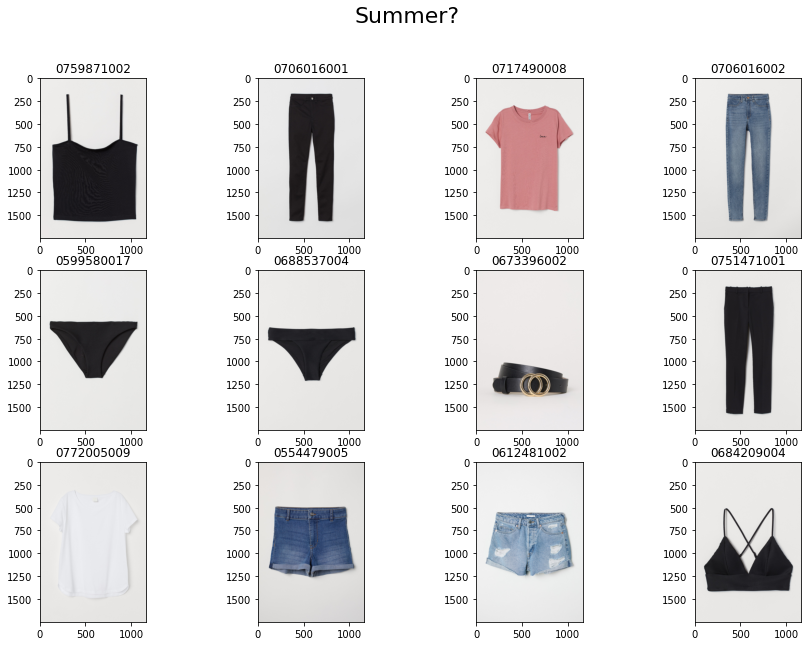

In [29]:
def image_lookup_path(g_id):
    im = (
        f"../input/h-and-m-personalized-fashion-recommendations/images/{g_id[:3]}"
        + "/"
        + g_id
        + ".jpg"
    )
    return im


fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()
fig.suptitle("Summer?", fontsize=22)
for i in range(len(summer_UK_19_top)):
    ax[i].title.set_text(summer_UK_19_top[i])
    im = imread(image_lookup_path(summer_UK_19_top[i]))
    ax[i].imshow(im)

plt.show()

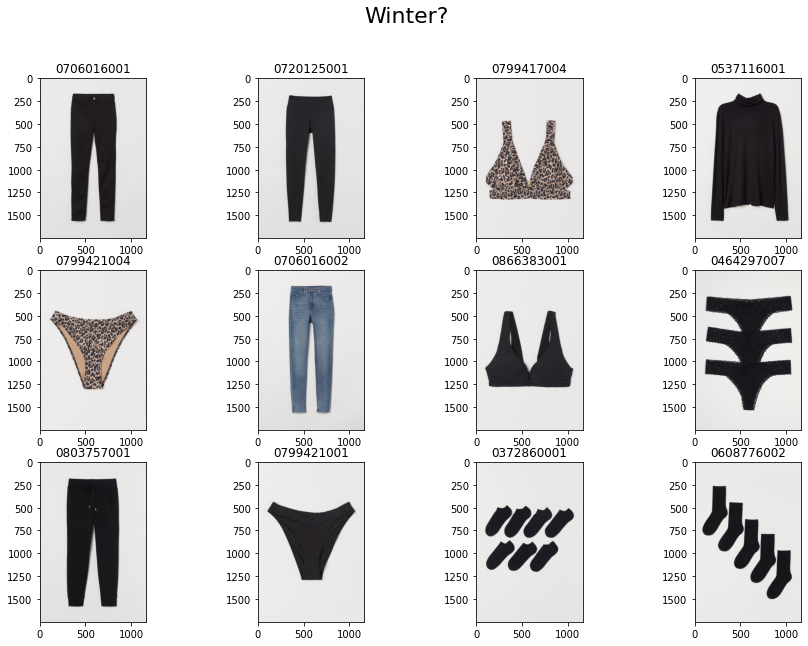

In [30]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()
fig.suptitle("Winter?", fontsize=22)

for i in range(len(winter_UK_19_20_top)):
    ax[i].title.set_text(winter_UK_19_20_top[i])
    im = imread(image_lookup_path(winter_UK_19_20_top[i]))
    ax[i].imshow(im)

plt.show()

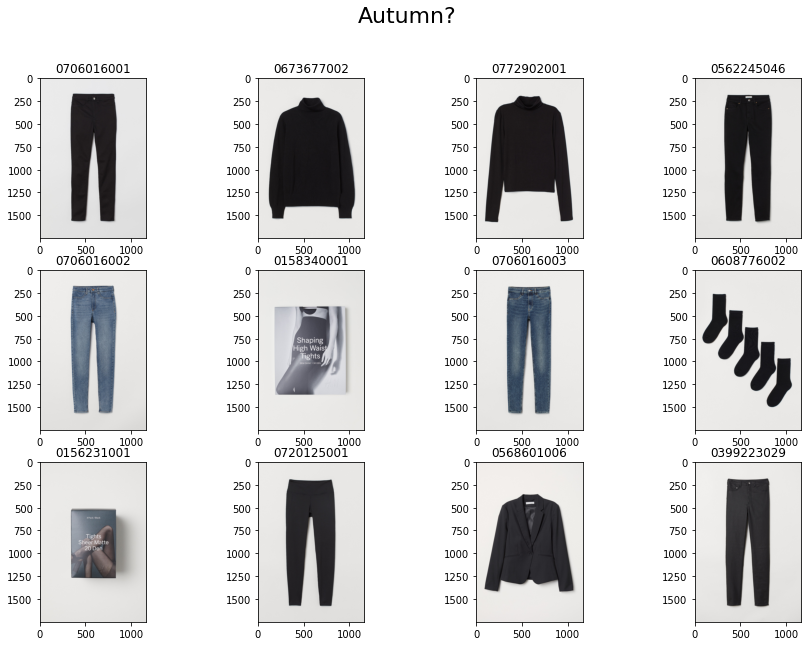

In [31]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()
fig.suptitle("Autumn?", fontsize=22)

for i in range(len(autumn_UK_19_top)):
    ax[i].title.set_text(autumn_UK_19_top[i])
    im = imread(image_lookup_path(autumn_UK_19_top[i]))
    ax[i].imshow(im)

plt.show()

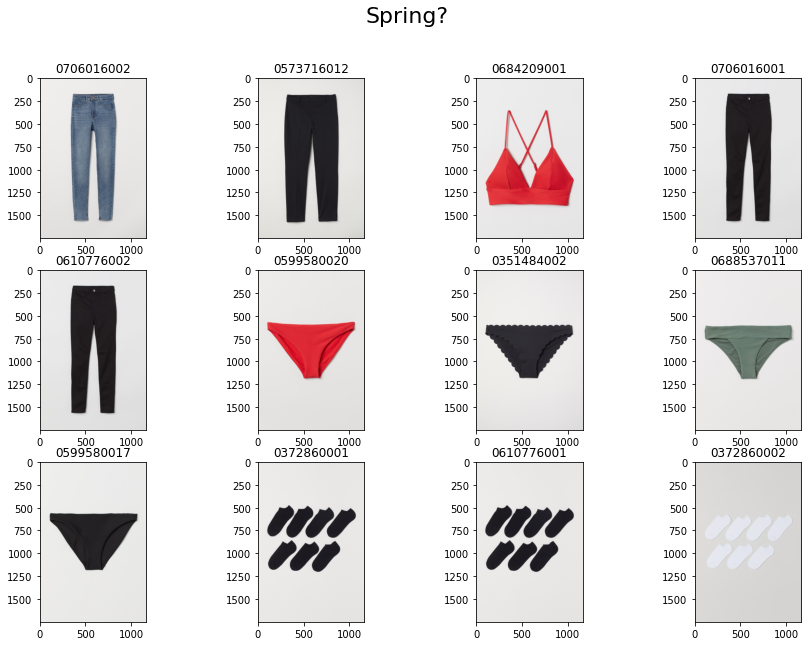

In [32]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()
fig.suptitle("Spring?", fontsize=22)
for i in range(len(spring_UK_19_top)):
    ax[i].title.set_text(spring_UK_19_top[i])
    try:
        im = imread(image_lookup_path(spring_UK_19_top[i]))
    except:
        pass
    ax[i].imshow(im)

plt.show()